# Notebook 1: Setup, Exploration & Cleaning

![Data Science Workflow Overview](../media/overview.jpeg)

**Phases 1-3:** Project Setup, Data Exploration, and Data Cleaning

**Dataset:** NYC Taxi Trip Dataset

**Focus:** Getting data ready for analysis - loading, understanding, and cleaning messy real-world data.

---

**Where we are:** This is the foundation of our data science project. We're taking raw, messy data and making it ready for analysis. Everything that follows depends on getting this right.

**What we'll accomplish:**
- Load and inspect our dataset
- Understand data quality issues
- Clean the data systematically
- Prepare for feature engineering (Notebook 2)

**Why this matters:** Real-world data is never perfect. Learning to systematically identify and fix issues is 80% of data science work. The patterns we discover here will guide our entire analysis.

**The big picture:**
- **Notebook 1 (this one):** Make data clean
- **Notebook 2:** Make data useful (add features, reshape, aggregate)
- **Notebook 3:** Make data ready for modeling
- **Notebook 4:** Build and evaluate models

---

## Phase 1: Project Setup & Data Acquisition

### Learning Objectives

- Set up the analysis environment
- Load data from files
- Perform initial data inspection
- Understand data structure and schema

### Step 1: Import Libraries

In [1]:
# Core data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter display
from IPython.display import display, Markdown

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display options for readability preferences
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

display(Markdown("**Libraries imported successfully!**"))
display(Markdown(f"- pandas version: `{pd.__version__}`"))
display(Markdown(f"- numpy version: `{np.__version__}`"))

**Libraries imported successfully!**

- pandas version: `2.3.3`

- numpy version: `2.3.5`

### Step 2: Load the Data

**NYC Taxi Trip Dataset**

**Source:** [NYC Taxi & Limousine Commission (TLC)](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

We'll use actual NYC Taxi Trip data downloaded from the NYC TLC website. The data is available in Parquet or CSV format.

**What is Parquet?** Parquet is a columnar storage format that's faster and more efficient than CSV for large datasets. It preserves data types and compresses data automatically. Think of it as a smarter CSV that pandas can read directly.

In [2]:
# Load actual NYC Taxi Trip data
# Download from: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
import os

# Check for data file (downloaded by download_data.sh)
data_file = 'data/yellow_tripdata_2023-01.parquet'

if not os.path.exists(data_file):
    display(Markdown("### Data File Not Found"))
    display(Markdown("""
Please run `download_data.sh` to download the data:
```bash
chmod +x download_data.sh
./download_data.sh
```
"""))
    raise FileNotFoundError(f"NYC Taxi data file not found: {data_file}. Run download_data.sh first.")

display(Markdown(f"Loading NYC Taxi Trip data from: `{data_file}`"))

# Load data - Parquet format (requires pyarrow, included in requirements.txt)
df = pd.read_parquet(data_file)
display(Markdown(f"**Loaded Parquet file:** {len(df):,} rows"))

Loading NYC Taxi Trip data from: `data/yellow_tripdata_2023-01.parquet`

**Loaded Parquet file:** 3,066,766 rows

Now let's standardize the column names and parse datetime columns:

In [3]:
# Standardize column names (NYC TLC uses 'tpep_' prefix for Yellow taxis)
df = df.rename(columns={
    'tpep_pickup_datetime': 'pickup_datetime',
    'tpep_dropoff_datetime': 'dropoff_datetime'
})

# Parse datetime columns immediately
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])

# Load NYC TLC Data Dictionary from YAML
import yaml

with open('nyc_tlc_data_dict.yaml', 'r') as f:
    tlc_dict = yaml.safe_load(f)

# Convert categorical codes to labeled categories
df['VendorID'] = df['VendorID'].map(tlc_dict['vendor']).astype('category')
df['RatecodeID'] = df['RatecodeID'].map(tlc_dict['ratecode']).astype('category')
df['payment_type'] = df['payment_type'].map(tlc_dict['payment_type']).astype('category')
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map(tlc_dict['store_and_fwd_flag']).astype('category')

# Location IDs are categorical zone codes (not numeric quantities)
# Human-readable zone names/boroughs are added in Notebook 2 via taxi_zone_lookup.csv
df['PULocationID'] = df['PULocationID'].astype('category')
df['DOLocationID'] = df['DOLocationID'].astype('category')

# Calculate total_amount if not present (sum of fare components)
if 'total_amount' not in df.columns:
    fare_components = ['fare_amount', 'tip_amount', 'tolls_amount',
                      'extra', 'mta_tax', 'improvement_surcharge']
    available_components = [col for col in fare_components if col in df.columns]
    df['total_amount'] = df[available_components].sum(axis=1)
    display(Markdown(f"✅ Calculated `total_amount` from {len(available_components)} components"))

display(Markdown("### ✅ Data Loaded Successfully"))
display(pd.DataFrame({
    'Metric': ['Total trips', 'Columns', 'Sample columns', 'Date range'],
    'Value': [
        f"{len(df):,}",
        len(df.columns),
        ', '.join(list(df.columns)[:5]) + '...',
        f"{df['pickup_datetime'].min()} to {df['pickup_datetime'].max()}"
    ]
}))

### ✅ Data Loaded Successfully

,Metric,Value
0,Total trips,"3,066,766"
1,Columns,19
2,Sample columns,"VendorID, pickup_datetime, dropoff_datetime, p..."
3,Date range,2008-12-31 23:01:42 to 2023-02-01 00:56:53


### 🐛 Debugging Tips: Data Loading Issues

If you encounter problems loading data, here are common issues and solutions:

**Problem: FileNotFoundError**
- Check file path: `os.path.exists('data/yellow_tripdata_2023-01.parquet')`
- Run download script: `./download_data.sh`
- Check current directory: `os.getcwd()` (should be in `11/demo/`)

**Problem: ImportError for pyarrow**
- Install pyarrow: `pip install pyarrow` or `uv pip install pyarrow`
- Restart kernel after installation

**Problem: MemoryError loading large file**
- Sample data: `df = pd.read_parquet(file).sample(n=100000)`
- Close other applications to free memory

### Step 3: Initial Data Inspection

Now that we've loaded the data, we need to understand its structure and quality. This initial inspection helps us identify potential issues before diving deeper into analysis.

**What to look for:**

- Dataset size (rows and columns)
- Column names and data types
- Memory usage (important for large datasets)
- Sample of actual data values
- Summary statistics
- Missing data patterns

In [4]:
# Basic information about the dataset
display(Markdown("# 📊 Dataset Overview"))

display(Markdown(f"**Shape:** {df.shape[0]:,} rows × {df.shape[1]} columns"))
display(Markdown(f"**Memory usage:** {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB"))

# Show column information with data types and non-null counts
display(Markdown("### 📋 Column Summary"))
df.info()

# Show example values for each column
display(Markdown("### 👀 Example Values (First Row)"))
display(df.head(1).T)

# 📊 Dataset Overview

**Shape:** 3,066,766 rows × 19 columns

**Memory usage:** 327.59 MB

### 📋 Column Summary

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3066766 entries, 0 to 3066765
Data columns (total 19 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               category      
 1   pickup_datetime        datetime64[us]
 2   dropoff_datetime       datetime64[us]
 3   passenger_count        float64       
 4   trip_distance          float64       
 5   RatecodeID             category      
 6   store_and_fwd_flag     category      
 7   PULocationID           category      
 8   DOLocationID           category      
 9   payment_type           category      
 10  fare_amount            float64       
 11  extra                  float64       
 12  mta_tax                float64       
 13  tip_amount             float64       
 14  tolls_amount           float64       
 15  improvement_surcharge  float64       
 16  total_amount           float64       
 17  congestion_surcharge   float64       
 18  airport_fee           

### 👀 Example Values (First Row)

,0
VendorID,VeriFone
pickup_datetime,2023-01-01 00:32:10
dropoff_datetime,2023-01-01 00:40:36
passenger_count,1.0
trip_distance,0.97
RatecodeID,Standard
store_and_fwd_flag,Not store and forward
PULocationID,161
DOLocationID,141
payment_type,Cash


**Interpreting the output:** The shape tells us how much data we're working with. Column names help us understand what information is available. Data types are crucial - we need to ensure datetime columns are properly parsed, and numeric columns are numeric (not strings). Memory usage helps us plan for processing - large datasets may require chunking or sampling.

Now let's look at actual data values to see what the records look like:

In [5]:
# First few rows
display(Markdown("# 👀 First 5 Rows"))
display(df.head())

# 👀 First 5 Rows

,VendorID,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,VeriFone,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,Standard,Not store and forward,161,141,Cash,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,VeriFone,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,Standard,Not store and forward,43,237,Credit card,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,VeriFone,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,Standard,Not store and forward,48,238,Credit card,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,Creative Mobile,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,Standard,Not store and forward,138,7,Credit card,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,VeriFone,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,Standard,Not store and forward,107,79,Credit card,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


**What to observe:** Look at the actual values - do they make sense? Are there any obvious data quality issues? Are the datetime columns properly formatted? Do numeric values seem reasonable?

Next, we'll compute summary statistics to understand the distributions of our numeric variables:

**Why transpose?** When you have many columns, `describe()` creates a wide table that's hard to read. Transposing (`.T`) flips rows and columns, so each variable gets its own row. This makes it much easier to scan the statistics.

In [6]:
# Summary statistics - transpose for easier reading when many columns
display(Markdown("# 📈 Summary Statistics"))

# Only include truly numeric columns (not categorical codes)
# Categorical columns like VendorID, payment_type have been converted to category dtype
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Transpose puts columns as rows, making it easier to read with many features
stats_df = df[numeric_cols].describe().T
stats_df = stats_df.round(2)  # Round for readability
display(stats_df)

# 📈 Summary Statistics

,count,mean,std,min,25%,50%,75%,max
passenger_count,2995023.0,1.36,0.90,0.00,1.00,1.00,1.00,9.00
trip_distance,3066766.0,3.85,249.58,0.00,1.06,1.80,3.33,258928.15
fare_amount,3066766.0,18.37,17.81,-900.00,8.60,12.80,20.50,1160.10
extra,3066766.0,1.54,1.79,-7.50,0.00,1.00,2.50,12.50
mta_tax,3066766.0,0.49,0.10,-0.50,0.50,0.50,0.50,53.16
tip_amount,3066766.0,3.37,3.83,-96.22,1.00,2.72,4.20,380.80
tolls_amount,3066766.0,0.52,2.02,-65.00,0.00,0.00,0.00,196.99
improvement_surcharge,3066766.0,0.98,0.18,-1.00,1.00,1.00,1.00,1.00
total_amount,3066766.0,27.02,22.16,-751.00,15.40,20.16,28.70,1169.40
congestion_surcharge,2995023.0,2.27,0.77,-2.50,2.50,2.50,2.50,2.50


**Note on categorical columns:** Columns like `VendorID`, `payment_type`, `RatecodeID`, and location IDs are categorical codes, not quantities. We converted them to `category` dtype so they won't appear in numeric summaries. Use `.value_counts()` to explore these:

In [7]:
# Explore categorical columns
display(Markdown("### 🏷️ Categorical Column Distributions"))
for col in ['VendorID', 'payment_type', 'RatecodeID']:
    display(Markdown(f"**{col}:**"))
    display(df[col].value_counts())

### 🏷️ Categorical Column Distributions

**VendorID:**

VendorID
VeriFone           2239399
Creative Mobile     827367
Name: count, dtype: int64

**payment_type:**

payment_type
Credit card    2411462
Cash            532241
Dispute          33297
No charge        18023
Name: count, dtype: int64

**RatecodeID:**

RatecodeID
Standard              2839305
JFK                    114239
Negotiated              15043
Newark                   8958
Nassau/Westchester       4366
Group ride                  6
Name: count, dtype: int64

**Key insights from summary statistics:**

- **Mean vs Median:** Large differences suggest skewed distributions (common with trip distances, fares)
  - *Why this matters:* If mean >> median, most values are small but a few are very large (right-skewed). This affects which models work well and whether we need transformations.
  - *Example:* If mean fare is $15 but median is $12, a few expensive trips are pulling the average up. Most trips are cheaper than average.
- **Min/Max values:** Extreme values may indicate outliers or data errors
  - *Example:* A trip distance of -5 miles is clearly an error. A distance of 100 miles might be valid (airport trip) or an error.
- **Standard deviation:** High std dev relative to mean suggests high variability
- **25th/75th percentiles:** Help identify the range where most data falls (the "typical" range)

Finally, we need to check for missing data, which is critical for data quality assessment:

In [8]:
# Check for missing values
display(Markdown("# 🔍 Missing Values"))

missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct.round(2)
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) == 0:
    display(Markdown("✅ **No missing values found!**"))
else:
    display(missing_df)

# 🔍 Missing Values

,Missing Count,Missing %
RatecodeID,84849,2.77
passenger_count,71743,2.34
store_and_fwd_flag,71743,2.34
payment_type,71743,2.34
congestion_surcharge,71743,2.34
airport_fee,71743,2.34


**Missing data considerations:**

- **High percentage (>10-20%):** May need to drop the column or use sophisticated imputation
- **Low percentage (<5%):** Can often be handled with simple imputation or removal
- **Patterns matter:** Is missingness random, or systematic (e.g., all missing on weekends)?
- **Domain knowledge:** Some missing values may be meaningful (e.g., missing tip = no tip)

**🔍 Notice identical missing counts?** If you see multiple columns with *exactly* the same number of missing values (e.g., `passenger_count`, `payment_type`, `store_and_fwd_flag` all at 71,743), that's not a coincidence! These values are missing from the **same rows** - likely a batch of incomplete records from a specific vendor, time period, or data collection issue. You can verify this:

In [9]:
# Check if missing values occur in the same rows
cols_with_same_missing = ['passenger_count', 'payment_type', 'store_and_fwd_flag']
missing_mask = df[cols_with_same_missing].isnull()
print(f"Rows where ALL are missing: {missing_mask.all(axis=1).sum():,}")
print(f"Rows where ANY is missing: {missing_mask.any(axis=1).sum():,}")
# If these numbers match, missingness is perfectly correlated

Rows where ALL are missing: 71,743
Rows where ANY is missing: 71,743


In [10]:
# Investigate: What characterizes the rows with missing data?
cols_with_same_missing = ['passenger_count', 'payment_type', 'store_and_fwd_flag', 'congestion_surcharge', 'airport_fee']
cols_available = [c for c in cols_with_same_missing if c in df.columns]
missing_mask = df[cols_available].isnull()

rows_with_missing = df[missing_mask.all(axis=1)]
rows_complete = df[~missing_mask.any(axis=1)]

display(Markdown("### 🔍 What's different about rows with missing data?"))
display(Markdown(f"**Rows with ALL missing:** {len(rows_with_missing):,}"))
display(Markdown(f"**Rows with NONE missing:** {len(rows_complete):,}"))

# Check vendor distribution - is it one vendor's data?
display(Markdown("**By Vendor:**"))
vendor_comparison = pd.DataFrame({
    'Missing rows %': rows_with_missing['VendorID'].value_counts(normalize=True).round(3) * 100,
    'Complete rows %': rows_complete['VendorID'].value_counts(normalize=True).round(3) * 100
})
display(vendor_comparison)

# Check time distribution - are missing rows from a specific period?
display(Markdown("**By Date Range:**"))
display(pd.DataFrame({
    'Metric': ['Earliest pickup', 'Latest pickup', 'Count'],
    'Missing rows': [
        rows_with_missing['pickup_datetime'].min(), 
        rows_with_missing['pickup_datetime'].max(),
        f"{len(rows_with_missing):,}"
    ],
    'Complete rows': [
        rows_complete['pickup_datetime'].min(), 
        rows_complete['pickup_datetime'].max(),
        f"{len(rows_complete):,}"
    ]
}))

# Check if missing rows cluster on specific dates
display(Markdown("**Missing rows by date (top 10 dates):**"))
missing_by_date = rows_with_missing.groupby(rows_with_missing['pickup_datetime'].dt.date).size().sort_values(ascending=False)
display(missing_by_date.head(10).to_frame('missing_count'))

### 🔍 What's different about rows with missing data?

**Rows with ALL missing:** 71,743

**Rows with NONE missing:** 2,995,023

**By Vendor:**

,Missing rows %,Complete rows %
VendorID,,
VeriFone,65.6,73.2
Creative Mobile,34.4,26.8


**By Date Range:**

,Metric,Missing rows,Complete rows
0,Earliest pickup,2023-01-01 00:00:00,2008-12-31 23:01:42
1,Latest pickup,2023-01-31 23:58:58,2023-02-01 00:56:53
2,Count,"71,743","2,995,023"


**Missing rows by date (top 10 dates):**

,missing_count
pickup_datetime,
2023-01-19,3482
2023-01-01,3466
2023-01-25,3147
2023-01-12,3141
2023-01-26,2713
2023-01-28,2526
2023-01-13,2511
2023-01-21,2505
2023-01-27,2490


---

## Phase 2: Data Exploration & Understanding

**What we're about to do:** Before cleaning, we need to understand our data deeply. This phase is like a detective investigation - we're looking for clues about data quality, patterns, and relationships.

**Why this comes first:** 
- We can't clean effectively without understanding what's normal vs. abnormal
- Visualizations reveal patterns that summary statistics miss
- Relationships between variables guide our cleaning strategy

**What you'll learn:**
- How to visualize distributions to spot skewness and outliers
- How to identify temporal patterns (since our data has time structure)
- How to discover relationships between variables
- How to spot data quality issues visually

**What to watch for:** 
- Distributions that look "wrong" (e.g., negative distances)
- Patterns that don't make sense (e.g., fares that don't correlate with distance)
- Missing data patterns (random vs. systematic)

### Learning Objectives

- Understand data distributions
- Identify relationships between variables
- Create initial visualizations
- Spot potential data quality issues

### Step 1: Basic Statistics and Distributions

Visualizing distributions helps us understand the shape of our data, identify potential outliers, and see if variables are normally distributed or skewed. This is crucial before any modeling or analysis.

**Why distributions matter:**

- **Skewed distributions** may need transformation (log, square root)
- **Outliers** can heavily influence models
- **Bimodal distributions** suggest subgroups in the data
- **Normal distributions** are ideal for many statistical methods

Let's start by creating histograms for our key numeric variables:

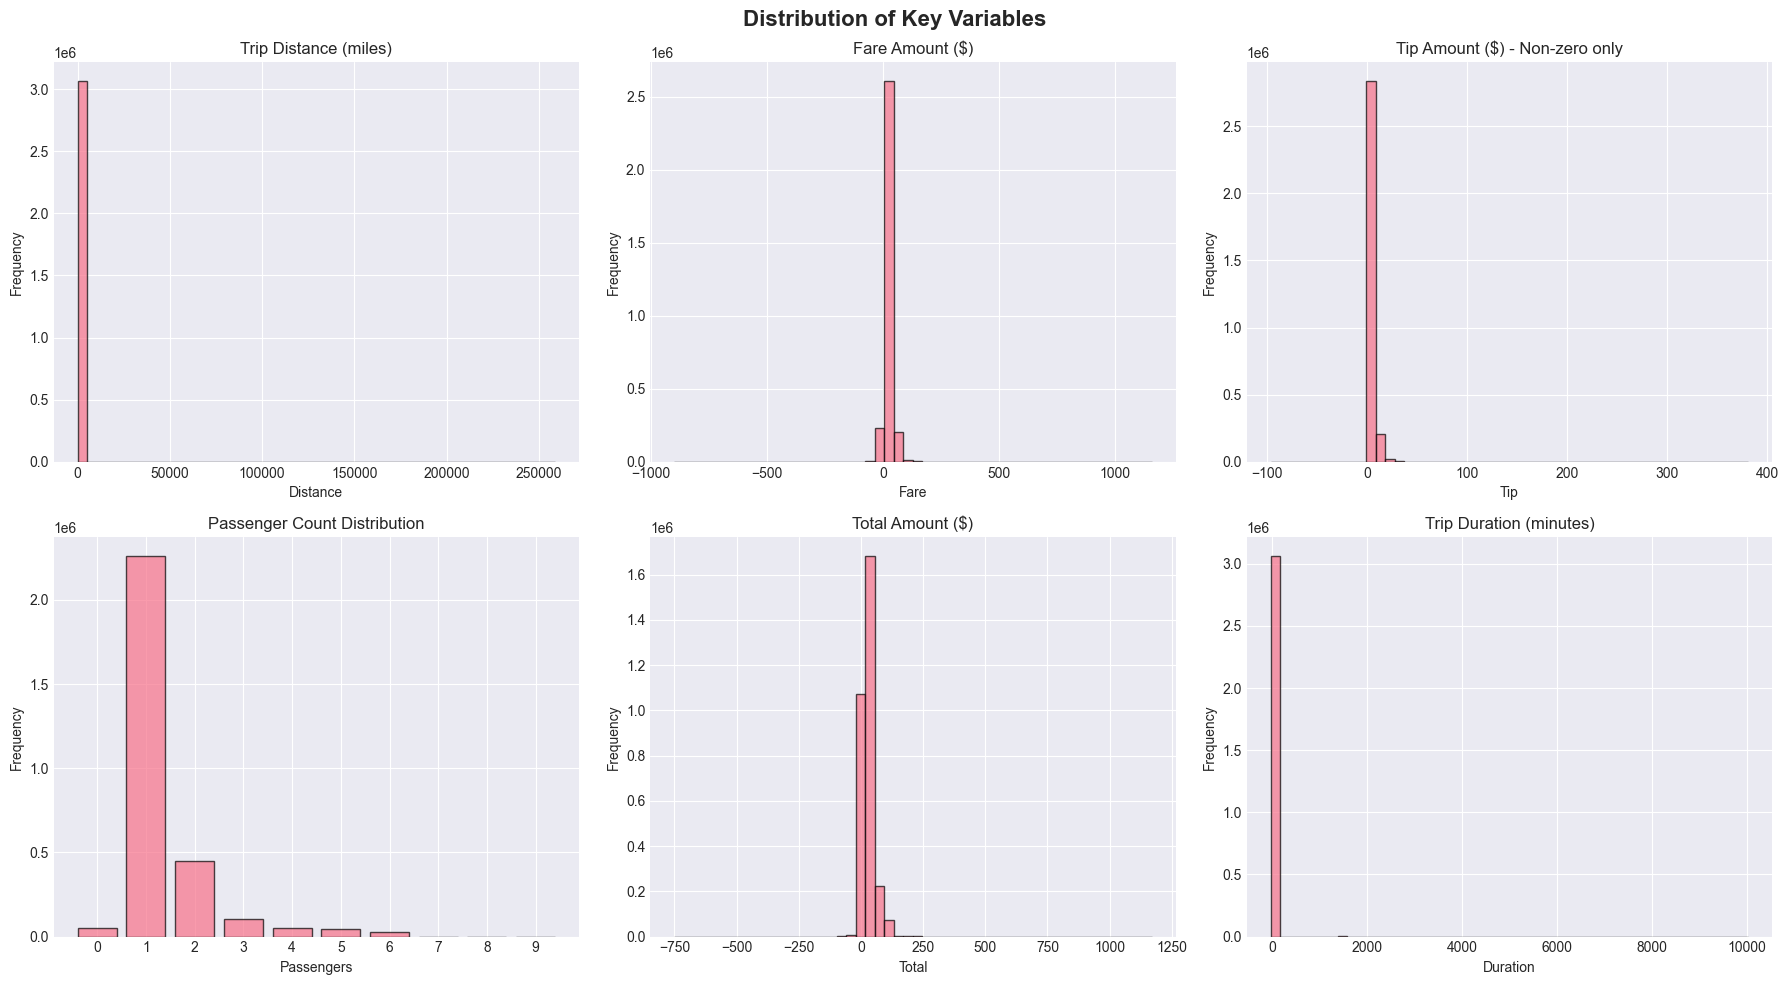

In [11]:
# Distribution of key numeric variables
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribution of Key Variables', fontsize=16, fontweight='bold')

# Trip distance
axes[0, 0].hist(df['trip_distance'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Trip Distance (miles)')
axes[0, 0].set_xlabel('Distance')
axes[0, 0].set_ylabel('Frequency')

# Fare amount
axes[0, 1].hist(df['fare_amount'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Fare Amount ($)')
axes[0, 1].set_xlabel('Fare')
axes[0, 1].set_ylabel('Frequency')

# Tip amount (excluding zeros)
tips_nonzero = df['tip_amount'].dropna()
axes[0, 2].hist(tips_nonzero, bins=50, edgecolor='black', alpha=0.7)
axes[0, 2].set_title('Tip Amount ($) - Non-zero only')
axes[0, 2].set_xlabel('Tip')
axes[0, 2].set_ylabel('Frequency')

# Passenger count
passenger_counts = df['passenger_count'].value_counts().sort_index()
axes[1, 0].bar(passenger_counts.index, passenger_counts.values, edgecolor='black', alpha=0.7)
axes[1, 0].set_title('Passenger Count Distribution')
axes[1, 0].set_xlabel('Passengers')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_xticks(passenger_counts.index)

# Total amount
axes[1, 1].hist(df['total_amount'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Total Amount ($)')
axes[1, 1].set_xlabel('Total')
axes[1, 1].set_ylabel('Frequency')

# Trip duration (calculate from datetime columns)
df['trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds() / 60  # minutes
axes[1, 2].hist(df['trip_duration'], bins=50, edgecolor='black', alpha=0.7)
axes[1, 2].set_title('Trip Duration (minutes)')
axes[1, 2].set_xlabel('Duration')
axes[1, 2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

**What to look for in these distributions:**

- **Trip distance:** Likely right-skewed (many short trips, few very long ones)
- **Fare amount:** Should correlate with distance; watch for negative or zero fares
- **Tip amount:** Many zeros (no tip), then a distribution of tip amounts
- **Passenger count:** Discrete values (1-6 typically); check for unrealistic values
- **Total amount:** Should be sum of fare + tip + taxes; verify consistency
- **Trip duration:** Right-skewed; very long durations may be errors

**Key observations:**

- Most distributions will be right-skewed (common in real-world data)
- Extreme values in the tails may be outliers or errors
- Bimodal patterns might indicate different trip types (e.g., airport vs local)

### Step 2: Trends Over Time

Time series analysis is a required component of this project. Let's examine how trip volume changes over time to identify patterns, seasonality, and anomalies.

**Why temporal patterns matter:**

- **Daily patterns:** Rush hours, lunch breaks, late night
- **Weekly patterns:** Weekday vs weekend differences
- **Monthly patterns:** Seasonal effects, holidays
- **Anomalies:** Unusual days (events, weather, holidays)

Let's aggregate trips by date and visualize the trend:

**Raw date range:** 2008-12-31 to 2023-02-01 (36 unique dates)

**Valid dates (≥1,000 trips):** 2023-01-01 to 2023-01-31 (31 days)

⚠️ **Filtered out 5 dates with <1,000 trips (likely data errors)**

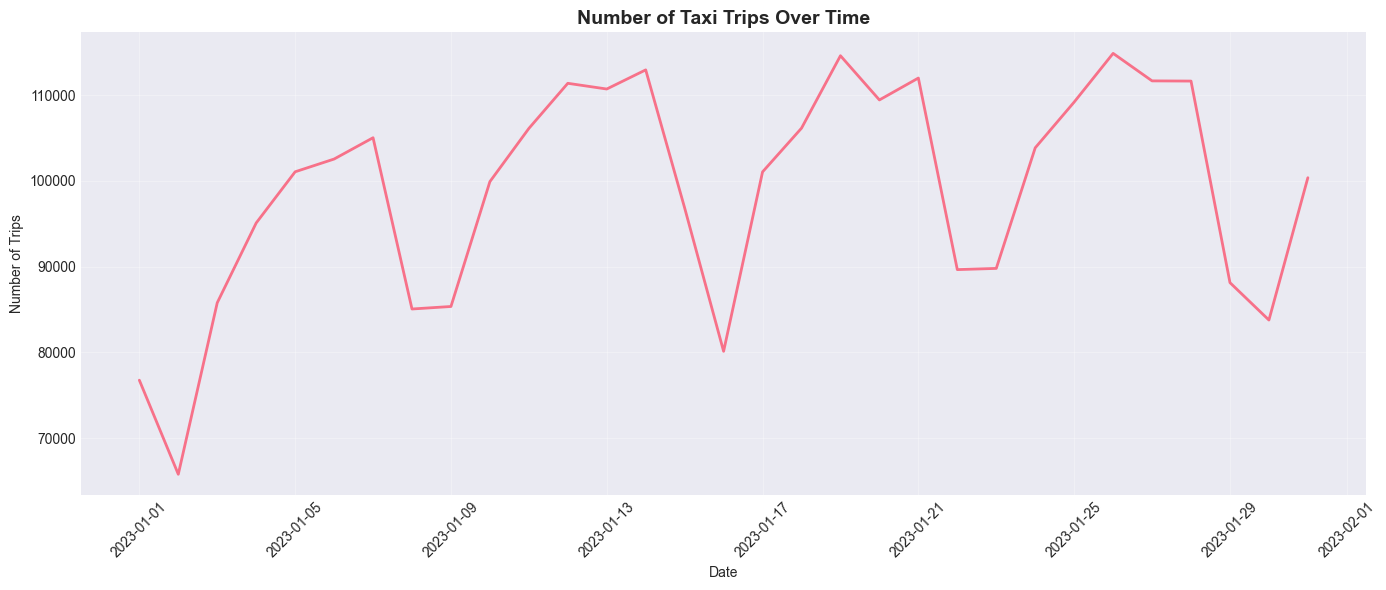

### 📅 Trip Volume Summary

,Metric,Value
0,Average trips/day,"98,926"
1,Peak day,2023-01-26
2,Peak volume,"114,877 trips"
3,Low day,2023-01-02
4,Low volume,"65,777 trips"


In [12]:
# Plot trips over time to see temporal patterns
df['pickup_date'] = df['pickup_datetime'].dt.date
trips_by_date = df.groupby('pickup_date').size()

# Filter to dates with meaningful data (at least 1000 trips)
# This handles outlier dates from data errors
MIN_TRIPS_PER_DAY = 1000
valid_dates = trips_by_date[trips_by_date >= MIN_TRIPS_PER_DAY]

display(Markdown(f"**Raw date range:** {trips_by_date.index.min()} to {trips_by_date.index.max()} ({len(trips_by_date)} unique dates)"))
display(Markdown(f"**Valid dates (≥{MIN_TRIPS_PER_DAY:,} trips):** {valid_dates.index.min()} to {valid_dates.index.max()} ({len(valid_dates)} days)"))

if len(trips_by_date) != len(valid_dates):
    display(Markdown(f"⚠️ **Filtered out {len(trips_by_date) - len(valid_dates)} dates with <{MIN_TRIPS_PER_DAY:,} trips (likely data errors)**"))

plt.figure(figsize=(14, 6))
plt.plot(valid_dates.index, valid_dates.values, linewidth=2)
plt.title('Number of Taxi Trips Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

display(Markdown("### 📅 Trip Volume Summary"))
display(pd.DataFrame({
    'Metric': ['Average trips/day', 'Peak day', 'Peak volume', 'Low day', 'Low volume'],
    'Value': [
        f"{valid_dates.mean():,.0f}",
        valid_dates.idxmax(),
        f"{valid_dates.max():,} trips",
        valid_dates.idxmin(),
        f"{valid_dates.min():,} trips"
    ]
}))

**Interpreting the time series plot:**

- **Trend:** Is trip volume increasing, decreasing, or stable?
- **Weekly pattern:** Look for regular dips (weekends typically have fewer trips)
- **Outliers:** Days with unusually high or low trip counts (holidays, events, data issues)
- **Variability:** How much does daily volume fluctuate?

**Common patterns in taxi data:**

- Lower volume on weekends
- Higher volume during rush hours
- Holiday effects (New Year's Eve, Thanksgiving)
- Weather impacts (snow, rain increase demand)

### Step 3: Relationships Between Variables

Understanding relationships between variables helps us identify which features might be useful for modeling and which might be redundant (highly correlated).

**Why correlation matters:**

- **Feature selection:** Highly correlated features may be redundant
- **Model assumptions:** Some models assume independence
- **Business insights:** Understanding what drives fares, tips, etc.

Let's start with a scatter plot to visualize the relationship between distance and fare:

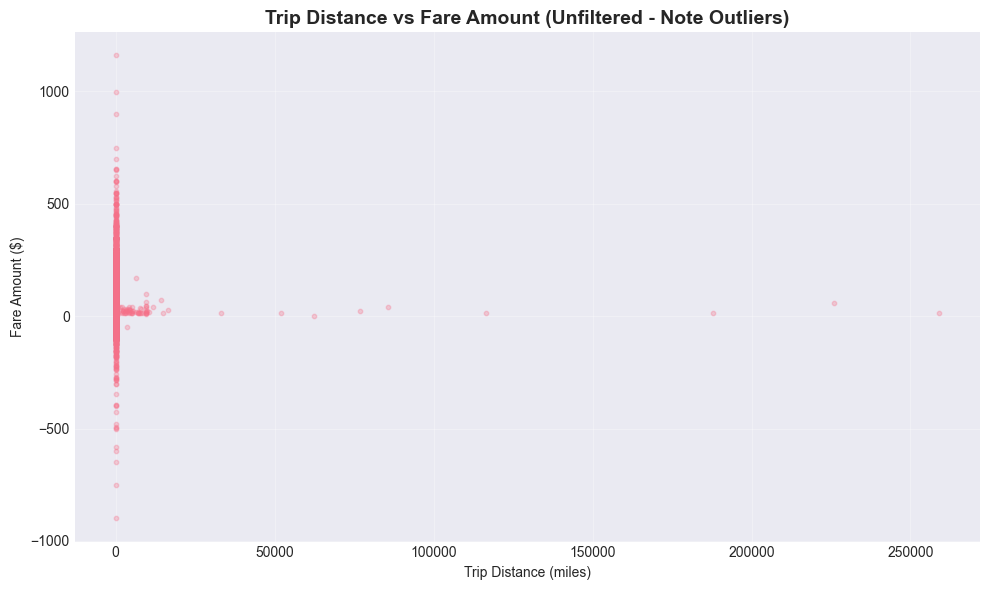

In [13]:
# Scatter plot: Distance vs Fare (unfiltered - shows outliers)
plt.figure(figsize=(10, 6))
plt.scatter(df['trip_distance'], df['fare_amount'], alpha=0.3, s=10)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.title('Trip Distance vs Fare Amount (Unfiltered - Note Outliers)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Filtered view:** 3,040,236 trips (fare > $0, distance < 50 mi)

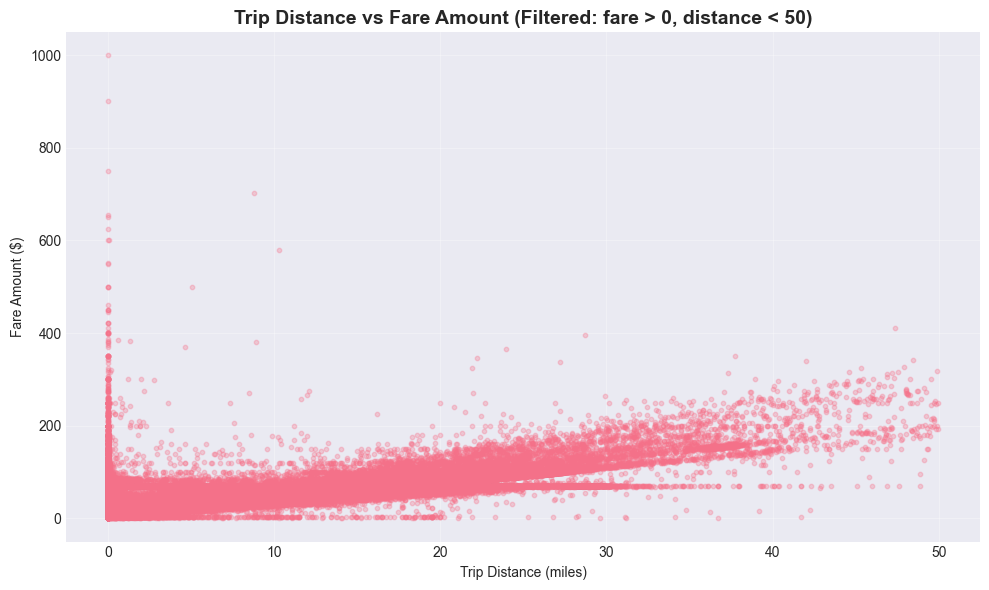

In [14]:
# Scatter plot: Distance vs Fare (filtered to reasonable ranges)
df_filtered = df[(df['fare_amount'] > 0) & (df['trip_distance'] < 50)]
display(Markdown(f"**Filtered view:** {len(df_filtered):,} trips (fare > $0, distance < 50 mi)"))

plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['trip_distance'], df_filtered['fare_amount'], alpha=0.3, s=10)
plt.xlabel('Trip Distance (miles)')
plt.ylabel('Fare Amount ($)')
plt.title('Trip Distance vs Fare Amount (Filtered: fare > 0, distance < 50)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**What to observe in the scatter plots:**

- **Positive relationship:** Longer trips should cost more (expected)
- **Linear vs non-linear:** Is the relationship linear or curved?
- **Outliers:** Points far from the main cluster (e.g., very short trips with high fares, or very long trips with low fares)
- **Clusters:** Multiple groups might indicate different fare structures (e.g., airport flat rates)

**Expected patterns:**

- Strong positive correlation (longer trips = higher fares)
- Some variation due to traffic, time of day, tolls
- Outliers might be data errors or special fare types

Now let's compute a correlation matrix to quantify relationships between all numeric variables:

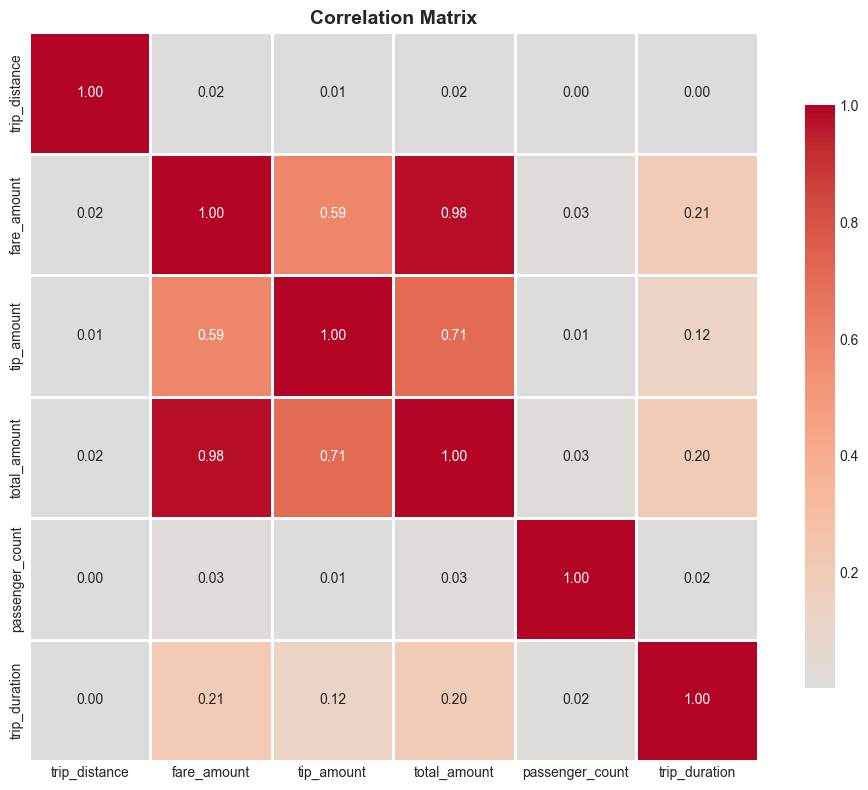

In [15]:
# Correlation matrix
numeric_cols = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 'passenger_count', 'trip_duration']
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 📊 Pairplot: Relationships Between Key Variables

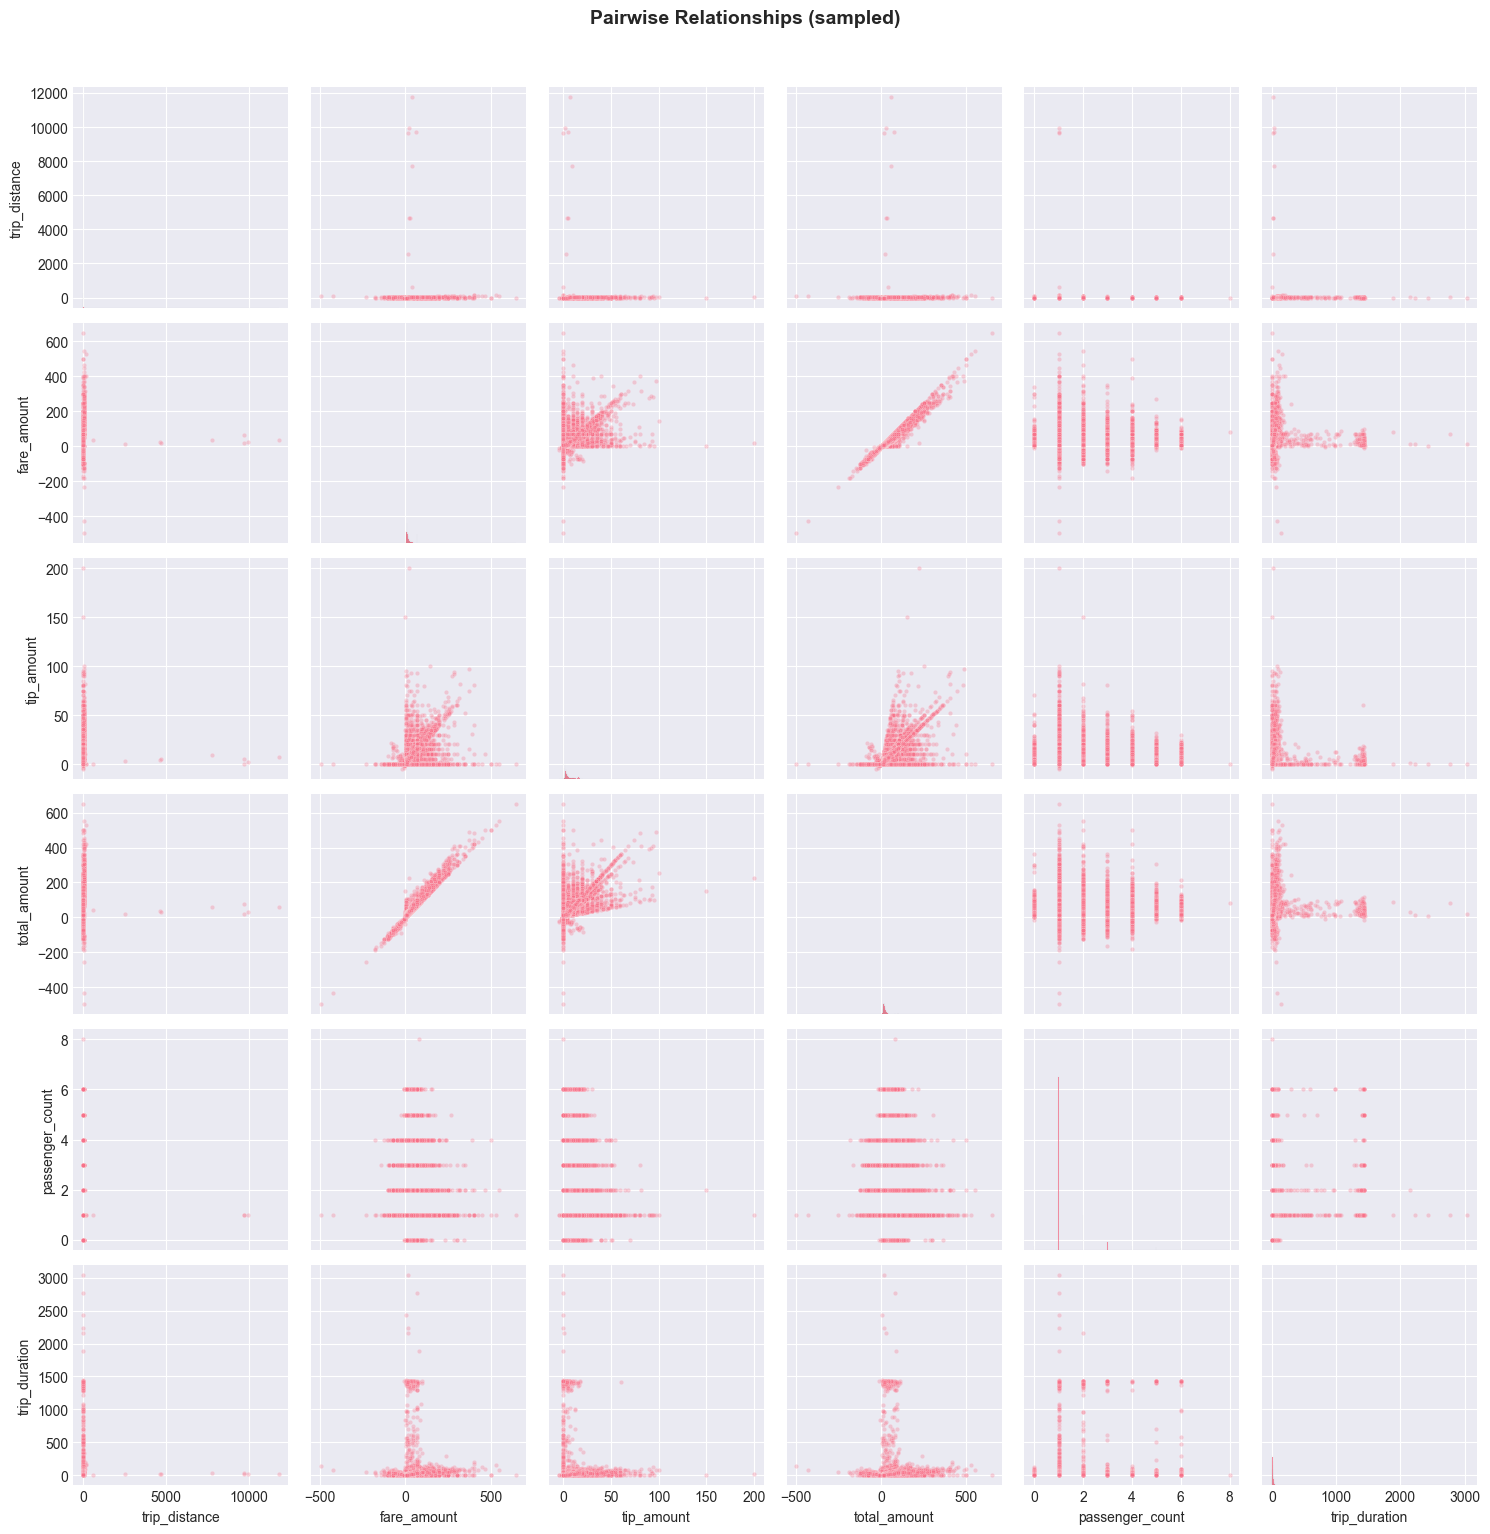

In [16]:
# Pairplot for visual inspection of relationships
# Sample to avoid slow rendering with large dataset
display(Markdown("### 📊 Pairplot: Relationships Between Key Variables"))
sample_size = min(500000, len(df))
df_sample = df[numeric_cols].sample(n=sample_size, random_state=42)

sns.pairplot(df_sample, diag_kind='hist', plot_kws={'alpha': 0.3, 's': 10})
plt.suptitle('Pairwise Relationships (sampled)', y=1.02, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

**Interpreting correlation values:**

- **|r| > 0.7:** Strong correlation (may indicate redundancy)
- **0.3 < |r| < 0.7:** Moderate correlation (useful relationships)
- **|r| < 0.3:** Weak correlation (little relationship)
- **Positive values:** Variables increase together
- **Negative values:** Variables move in opposite directions

**Expected correlations:**

- `trip_distance` ↔ `fare_amount`: Strong positive (longer trips cost more)
- `fare_amount` ↔ `total_amount`: Very strong positive (fare is major component)
- `trip_distance` ↔ `trip_duration`: Moderate positive (longer trips take more time, but traffic matters)
- `tip_amount` ↔ `fare_amount`: Moderate positive (higher fares often get higher tips)

---

## Phase 3: Data Cleaning & Preprocessing

**What we're about to do:** Now that we understand our data, we'll systematically fix issues. This is where we transform messy real-world data into clean, analysis-ready data.

**Why this matters:** 
- Dirty data leads to wrong conclusions
- Systematic cleaning is reproducible and defensible
- The decisions we make here affect everything that follows

**Our cleaning strategy:**
1. **Handle missing data** - Decide: impute, drop, or flag?
2. **Detect outliers** - Statistical methods + domain knowledge
3. **Validate ranges** - Do values make sense? (e.g., no negative fares)
4. **Remove duplicates** - Same trip recorded twice?
5. **Fix data types** - Ensure datetime is datetime, numeric is numeric

**Key principle:** Every cleaning decision should be defensible. We'll explain our reasoning for each choice.

### Learning Objectives

- Identify and handle missing data
- Detect and handle outliers
- Validate data ranges
- Clean data systematically

### Step 1: Missing Data Analysis

Before handling missing data, we need to understand the extent and pattern of missingness. This informs our strategy for dealing with it.

**Why missing data analysis matters:**

- **Extent:** How much data is missing? (affects our sample size)
- **Pattern:** Is missingness random or systematic? (affects imputation strategy)
- **Impact:** Which variables are affected? (affects which features we can use)

Let's create a comprehensive missing data report:

In [17]:
display(Markdown("# 🔍 Missing Data Analysis"))

# Detailed missing data analysis with data types for context
missing_analysis = pd.DataFrame({
    'Column': df.columns,
    'Type': df.dtypes.astype(str).values,
    'Missing': df.isnull().sum().values,
    'Missing %': (df.isnull().sum() / len(df) * 100).round(2).values
})
missing_analysis = missing_analysis[missing_analysis['Missing'] > 0].sort_values('Missing', ascending=False)

if len(missing_analysis) == 0:
    display(Markdown("✅ **No missing values found!**"))
else:
    display(missing_analysis)

# 🔍 Missing Data Analysis

,Column,Type,Missing,Missing %
5,RatecodeID,category,84849,2.77
3,passenger_count,float64,71743,2.34
6,store_and_fwd_flag,category,71743,2.34
9,payment_type,category,71743,2.34
17,congestion_surcharge,float64,71743,2.34
18,airport_fee,float64,71743,2.34


**Interpreting missing data:**

- **High percentage (>20%):** Consider dropping the column or using advanced imputation
- **Medium percentage (5-20%):** Can use imputation, but be cautious
- **Low percentage (<5%):** Usually safe to impute or drop rows
- **Systematic missingness:** All missing on weekends? All missing for certain trip types?

Now let's visualize the missing data pattern:

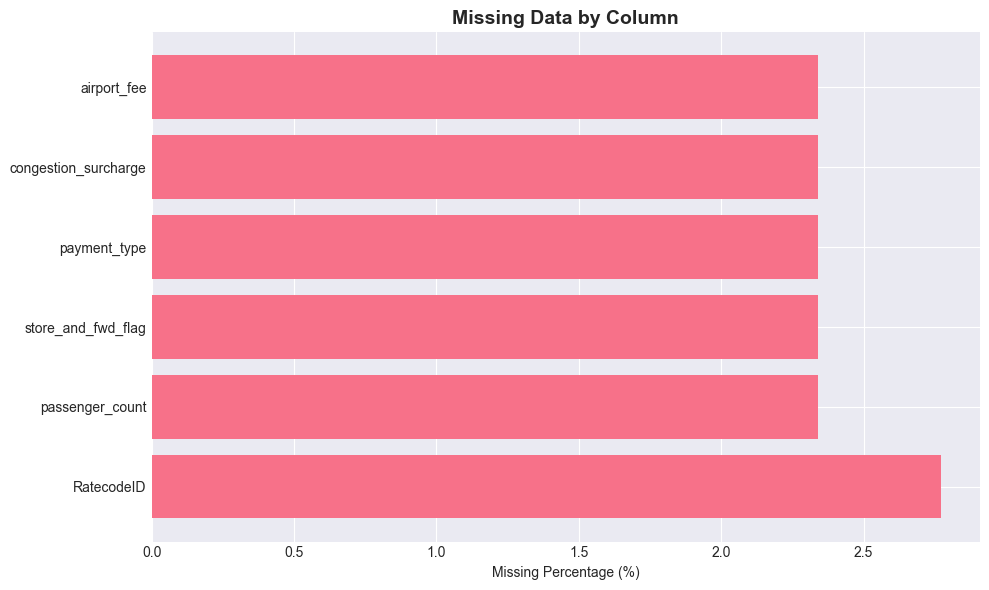

In [18]:
# Visualize missing data pattern
if len(missing_analysis) > 0:
    plt.figure(figsize=(10, 6))
    plt.barh(missing_analysis['Column'], missing_analysis['Missing %'])
    plt.xlabel('Missing Percentage (%)')
    plt.title('Missing Data by Column', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

**Visual insights:**

- Which columns have the most missing data?
- Are there patterns (e.g., all optional fields missing together)?
- Does missingness correlate with other variables?

### Step 2: Handle Missing Data

Now that we understand the missing data, we need to decide on a strategy. The approach depends on:

- **Type of variable:** Categorical vs numeric
- **Amount missing:** High vs low percentage
- **Domain knowledge:** Is missing meaningful? (e.g., missing tip = no tip)

**Common strategies:**

- **Drop rows:** If missing is rare and random
- **Drop columns:** If too much is missing
- **Impute with 0:** For counts/amounts where 0 is meaningful
- **Impute with median/mean:** For numeric variables
- **Impute with mode:** For categorical variables
- **Advanced imputation:** KNN, regression-based, etc.

For this dataset, let's handle tip_amount specifically:

In [19]:
# Strategy for handling missing data
# For tip_amount: Missing likely means no tip (0), but we'll be conservative
# and use median imputation for now

display(Markdown("## 🛠️ Handling Missing Data"))
display(Markdown(f"**Missing `tip_amount` before:** {df['tip_amount'].isnull().sum():,}"))

## 🛠️ Handling Missing Data

**Missing `tip_amount` before:** 0

**Decision point:** For `tip_amount`, we have two reasonable options:

1. **Fill with 0:** Assumes missing = no tip (common in taxi data)
2. **Fill with median:** More conservative, preserves distribution

We'll use median imputation to be conservative, but in practice, you might choose 0 based on domain knowledge:

In [20]:
# Option 1: Fill with 0 (assuming missing = no tip)
# df['tip_amount'] = df['tip_amount'].fillna(0)

# Option 2: Fill with median (more conservative)
df['tip_amount'] = df['tip_amount'].fillna(df['tip_amount'].median())

display(Markdown(f"**Missing `tip_amount` after:** {df['tip_amount'].isnull().sum()}"))

**Missing `tip_amount` after:** 0

**Note:** After imputing tip_amount, we should recalculate total_amount to ensure consistency:

In [21]:
# NYC taxi fare components (as of 2023)
MTA_TAX = 0.50  # Standard MTA state tax per trip

# Recalculate total_amount to ensure consistency after imputation
df['total_amount'] = df['fare_amount'] + df['tip_amount'] + MTA_TAX

display(Markdown("✅ **Missing data handling complete!**"))

✅ **Missing data handling complete!**

**Why recalculate?** If we imputed tip_amount, the total_amount might have been calculated before imputation, so we need to update it. The `MTA_TAX` constant makes it clear what the `0.5` represents - this is domain knowledge from NYC taxi regulations.

### 💡 Alternative Approach: Missing Data Strategies

We used median imputation for `tip_amount`, but there are other valid approaches:

| Method | When to Use | Pros | Cons |
|--------|-------------|------|------|
| **Fill with 0** | Missing = no tip (domain knowledge) | Simple, preserves meaning | Might underestimate |
| **Median imputation** | General purpose (our choice) | Preserves distribution | Doesn't account for patterns |
| **Mode imputation** | Categorical-like data | Simple | Might not represent missingness |
| **KNN imputation** | Missingness correlates with other variables | Uses relationships | More complex, slower |

**🔬 Try This:** Compare results using `fillna(0)` vs `fillna(median)`. How much does it affect downstream analysis?

**Answer:** For `passenger_count`, **median is better** than 0. Why? Zero passengers is invalid (no trip without passengers), while median (~1-2) represents typical trips. Using 0 would skew averages and models. General rule: **use median for numeric data, mode for categorical, only use 0 if it's a valid value**.

### Step 3: Outlier Detection

Outliers can significantly impact models and analysis. We need to identify them using statistical methods, then decide whether they're errors (remove) or valid extreme values (keep or transform).

**Why detect outliers:**

- **Model impact:** Outliers can heavily influence regression models
- **Data quality:** Extreme values may be data entry errors
- **Domain knowledge:** Some outliers are valid (e.g., very long airport trips)

**Common methods:**

- **IQR method:** Uses quartiles (robust to outliers)
- **Z-score method:** Uses standard deviations (assumes normal distribution)
- **Domain-based:** Use business rules (e.g., trips > 50 miles are errors)

Let's use the IQR (Interquartile Range) method, which is robust and doesn't assume normality.

**🔬 Try This First: Experiment with Outlier Detection**

Before we write the function, let's understand how outlier detection works by experimenting with different thresholds:

In [22]:
# Quick experiment: See how different IQR multipliers affect outlier detection
# Run this to understand the concept before using the function below

# Calculate quartiles manually to see what's happening
Q1 = df['trip_distance'].quantile(0.25)
Q3 = df['trip_distance'].quantile(0.75)
IQR = Q3 - Q1

print(f"Q1 (25th percentile): {Q1:.2f} miles")
print(f"Q3 (75th percentile): {Q3:.2f} miles")
print(f"IQR (middle 50% range): {IQR:.2f} miles")
print()

# Try different multipliers
for multiplier in [1.5, 2.0, 3.0]:
    lower = Q1 - multiplier * IQR
    upper = Q3 + multiplier * IQR
    outliers = df[(df['trip_distance'] < lower) | (df['trip_distance'] > upper)]
    print(f"IQR × {multiplier}: {len(outliers):,} outliers ({len(outliers)/len(df)*100:.2f}%)")
    print(f"  Range: {lower:.2f} to {upper:.2f} miles")
    print()

# Question: Which threshold makes sense for NYC taxi data?
# Consider: Airport trips to JFK are ~20 miles - are these outliers or valid trips?

Q1 (25th percentile): 1.06 miles
Q3 (75th percentile): 3.33 miles
IQR (middle 50% range): 2.27 miles

IQR × 1.5: 390,244 outliers (12.72%)
  Range: -2.35 to 6.74 miles

IQR × 2.0: 340,027 outliers (11.09%)
  Range: -3.48 to 7.87 miles

IQR × 3.0: 239,186 outliers (7.80%)
  Range: -5.75 to 10.14 miles



**Answer:** For NYC taxi data, **1.5× IQR is too aggressive** - it flags airport trips (~15-20 miles) as outliers when they're actually valid. The **2.0× or 3.0× multiplier** is more appropriate, or better yet, use **domain knowledge** (e.g., max distance = 50 miles to include all NYC area airports). This is why we combine statistical methods with domain expertise.

**Learning goal:** Understand that outlier detection isn't one-size-fits-all. The multiplier controls sensitivity - lower values catch more outliers (including valid extremes), higher values are more conservative.

**Visualizing IQR Bounds:**

Let's see what these bounds look like on actual data:

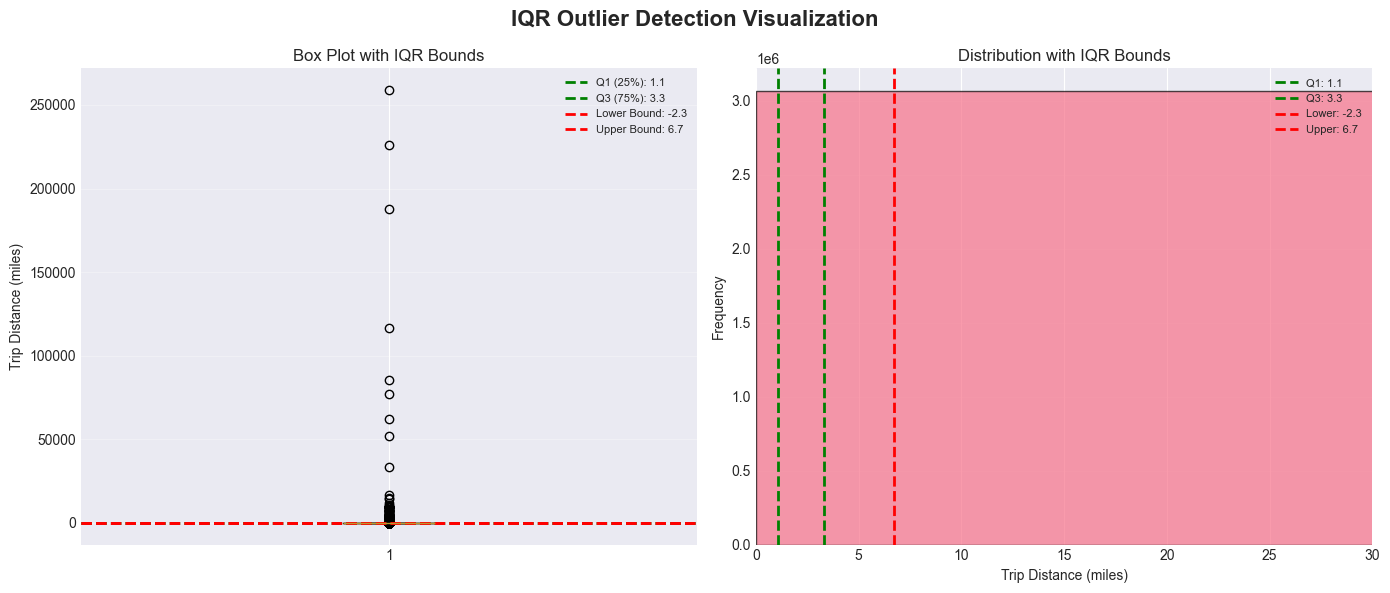


**What you're seeing:**
- **Box plot (left):** The box shows the IQR (Q1 to Q3). Whiskers extend to 1.5×IQR. Points beyond are outliers.
- **Histogram (right):** Most data is between the green lines (Q1-Q3). Red lines show outlier boundaries.
- **Key insight:** Values beyond red lines are statistical outliers, but they might be valid (e.g., airport trips).


In [23]:
# Visualize IQR outlier detection
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('IQR Outlier Detection Visualization', fontsize=16, fontweight='bold')

# Left: Boxplot (shows IQR visually)
axes[0].boxplot(df['trip_distance'].dropna(), vert=True)
axes[0].axhline(Q1, color='green', linestyle='--', linewidth=2, label=f'Q1 (25%): {Q1:.1f}')
axes[0].axhline(Q3, color='green', linestyle='--', linewidth=2, label=f'Q3 (75%): {Q3:.1f}')
axes[0].axhline(Q1 - 1.5*IQR, color='red', linestyle='--', linewidth=2, label=f'Lower Bound: {Q1-1.5*IQR:.1f}')
axes[0].axhline(Q3 + 1.5*IQR, color='red', linestyle='--', linewidth=2, label=f'Upper Bound: {Q3+1.5*IQR:.1f}')
axes[0].set_ylabel('Trip Distance (miles)')
axes[0].set_title('Box Plot with IQR Bounds')
axes[0].legend(loc='upper right', fontsize=8)
axes[0].grid(True, alpha=0.3, axis='y')

# Right: Histogram with bounds
axes[1].hist(df['trip_distance'], bins=100, alpha=0.7, edgecolor='black')
axes[1].axvline(Q1, color='green', linestyle='--', linewidth=2, label=f'Q1: {Q1:.1f}')
axes[1].axvline(Q3, color='green', linestyle='--', linewidth=2, label=f'Q3: {Q3:.1f}')
axes[1].axvline(Q1 - 1.5*IQR, color='red', linestyle='--', linewidth=2, label=f'Lower: {Q1-1.5*IQR:.1f}')
axes[1].axvline(Q3 + 1.5*IQR, color='red', linestyle='--', linewidth=2, label=f'Upper: {Q3+1.5*IQR:.1f}')
axes[1].set_xlabel('Trip Distance (miles)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution with IQR Bounds')
axes[1].legend(loc='upper right', fontsize=8)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].set_xlim(0, 30)  # Zoom in to see pattern clearly

plt.tight_layout()
plt.show()

display(Markdown("""
**What you're seeing:**
- **Box plot (left):** The box shows the IQR (Q1 to Q3). Whiskers extend to 1.5×IQR. Points beyond are outliers.
- **Histogram (right):** Most data is between the green lines (Q1-Q3). Red lines show outlier boundaries.
- **Key insight:** Values beyond red lines are statistical outliers, but they might be valid (e.g., airport trips).
"""))

Now let's create a reusable function:

In [24]:
display(Markdown("# 🎯 Outlier Detection"))

# Identify outliers using IQR method with Tukey fences
def detect_outliers_iqr(df, column, iqr_multiplier=1.5):
    """
    Detect outliers using the IQR (Interquartile Range) method.

    This is the Tukey fence method, which is robust and doesn't assume
    normal distribution. It's widely used in exploratory data analysis.

    Parameters:
    -----------
    df : DataFrame
        The data
    column : str
        Column name to check for outliers
    iqr_multiplier : float, default=1.5
        Tukey fence multiplier:
        - 1.5 = standard outlier detection (common choice)
        - 3.0 = extreme outlier detection (more conservative)

    Returns:
    --------
    tuple : (outliers DataFrame, lower_bound, upper_bound)
    """
    Q1 = df[column].quantile(0.25)  # 25th percentile
    Q3 = df[column].quantile(0.75)  # 75th percentile
    IQR = Q3 - Q1  # Interquartile range (middle 50% of data)

    # Tukey fences: standard statistical method for outlier detection
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR

    # Find values outside the fences
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# 🎯 Outlier Detection

**How IQR works:**

- **Q1 (25th percentile):** 25% of data below this value
- **Q3 (75th percentile):** 75% of data below this value
- **IQR = Q3 - Q1:** The "middle 50%" range
- **Bounds:** Q1 - 1.5×IQR (lower) and Q3 + 1.5×IQR (upper)
- **Outliers:** Values outside these bounds

Now let's check for outliers in trip distance:

In [25]:
# Check trip_distance outliers
distance_outliers, dist_lower, dist_upper = detect_outliers_iqr(df, 'trip_distance')

display(Markdown("### 🚕 Trip Distance Outliers"))
display(pd.DataFrame({
    'Metric': ['Lower bound', 'Upper bound', 'Number of outliers'],
    'Value': [
        f"{dist_lower:.2f} miles",
        f"{dist_upper:.2f} miles",
        f"{len(distance_outliers):,} ({len(distance_outliers)/len(df)*100:.2f}%)"
    ]
}))

### 🚕 Trip Distance Outliers

,Metric,Value
0,Lower bound,-2.35 miles
1,Upper bound,6.74 miles
2,Number of outliers,"390,244 (12.72%)"


**Interpreting trip distance outliers:**

- **Negative values:** Data errors (must remove)
- **Very high values (>50 miles):** Unusual for NYC, might be airport trips or errors
- **Zero values:** Data errors (trip must have distance)

Next, let's check fare amount:

In [26]:
# Check fare_amount outliers
fare_outliers, fare_lower, fare_upper = detect_outliers_iqr(df, 'fare_amount')

display(Markdown("### 💵 Fare Amount Outliers"))
display(pd.DataFrame({
    'Metric': ['Lower bound', 'Upper bound', 'Number of outliers'],
    'Value': [
        f"${fare_lower:.2f}",
        f"${fare_upper:.2f}",
        f"{len(fare_outliers):,} ({len(fare_outliers)/len(df)*100:.2f}%)"
    ]
}))

### 💵 Fare Amount Outliers

,Metric,Value
0,Lower bound,$-9.25
1,Upper bound,$38.35
2,Number of outliers,"325,228 (10.60%)"


**Interpreting fare outliers:**

- **Negative fares:** Data errors (must remove)
- **Zero fares:** Could be errors or promotional rides
- **Very high fares:** Might be valid (long trips, tolls, surcharges) or errors

Finally, let's check trip duration:

In [27]:
# Check trip_duration outliers (unrealistic trips)
duration_outliers, dur_lower, dur_upper = detect_outliers_iqr(df, 'trip_duration')

display(Markdown("### ⏱️ Trip Duration Outliers"))
display(pd.DataFrame({
    'Metric': ['Lower bound', 'Upper bound', 'Number of outliers'],
    'Value': [
        f"{dur_lower:.2f} minutes",
        f"{dur_upper:.2f} minutes",
        f"{len(duration_outliers):,} ({len(duration_outliers)/len(df)*100:.2f}%)"
    ]
}))

### ⏱️ Trip Duration Outliers

,Metric,Value
0,Lower bound,-9.66 minutes
1,Upper bound,35.08 minutes
2,Number of outliers,"170,615 (5.56%)"


**Interpreting duration outliers:**

- **Negative duration:** Data errors (dropoff before pickup - must remove)
- **Very short (<1 minute):** Might be errors or very short trips
- **Very long (>2 hours):** Unusual for NYC taxis, might be errors or special cases

### Step 4: Check for Duplicates

Duplicate records can occur due to data collection errors, system glitches, or legitimate re-submissions. We need to identify and handle them.

**Types of duplicates:**

- **Exact duplicates:** Identical rows (likely data errors)
- **Near-duplicates:** Same trip recorded multiple times (same location/time)

**Why remove duplicates:**

- **Model bias:** Duplicates give extra weight to certain observations
- **Data quality:** Indicates potential data collection issues
- **Memory/performance:** Reduces dataset size

Let's first check for completely identical rows:

In [28]:
# Check for duplicate rows
display(Markdown("# 🔄 Duplicate Detection"))

# Check for completely duplicate rows
n_duplicates = df.duplicated().sum()
display(Markdown(f"**Completely duplicate rows:** {n_duplicates:,}"))

# 🔄 Duplicate Detection

**Completely duplicate rows:** 0

**Interpreting exact duplicates:**

- **Zero duplicates:** Good data quality
- **Many duplicates:** May indicate data collection or processing issues
- **Few duplicates:** Might be legitimate (e.g., system retry)

Now let's check for near-duplicates - trips that have the same pickup/dropoff location and time:

In [29]:
# Check for duplicates based on key columns (same trip recorded twice)
# NYC TLC data uses location IDs (PULocationID, DOLocationID) instead of lat/long
# Note: If latitude/longitude coordinates were available, duplicate detection could be
# more robust using fuzzy matching (e.g., trips within ~100m of each other at similar times).
# For this dataset, exact matching on location IDs and timestamps is a reasonable approach.
key_cols = ['pickup_datetime', 'dropoff_datetime', 'PULocationID', 'DOLocationID']
# Only check if these columns exist
available_key_cols = [col for col in key_cols if col in df.columns]
if len(available_key_cols) >= 2:
    n_key_duplicates = df.duplicated(subset=available_key_cols).sum()
    display(Markdown(f"**Duplicate trips** (same pickup/dropoff location and time): {n_key_duplicates:,}"))
else:
    display(Markdown("⚠️ *Location columns not available for duplicate detection*"))

**Duplicate trips** (same pickup/dropoff location and time): 21,990

**Why check near-duplicates?**

- Same trip might be recorded multiple times due to system issues
- Location IDs are less precise than coordinates, so exact matches are reasonable
- If we had lat/long, we could use fuzzy matching (e.g., trips within 100m at similar times)

If we find duplicates, let's examine them:

In [30]:
# Show examples if any duplicates exist
if n_duplicates > 0:
    display(Markdown("### Example Duplicate Rows"))
    display(df[df.duplicated(keep=False)].head(10))

**What to look for:**

- Are duplicates truly identical, or do they differ in some columns?
- If they differ, which columns vary? (helps understand the issue)
- Should we keep the first occurrence, last, or merge them?

### Step 5: Handle Outliers

Now that we've identified outliers, we need to decide how to handle them. The strategy depends on:

- **Are they errors?** (remove them)
- **Are they valid but extreme?** (keep, cap, or transform)
- **Domain knowledge:** What makes sense for taxi trips in NYC?

**Common strategies:**

- **Remove:** If clearly errors (negative values, impossible combinations)
- **Cap:** Set extreme values to reasonable maximums
- **Transform:** Use log transformation for highly skewed data
- **Keep:** If valid extreme cases (e.g., airport trips)

Let's apply domain-specific cleaning rules:

In [31]:
# Handle outliers based on domain knowledge
display(Markdown("## 🧹 Handling Outliers"))

# Instead of dropping rows, we'll create an EXCLUSION FLAG
# This approach is better because:
# 1. Preserves original data for analysis
# 2. Transparent about what's being filtered
# 3. Can toggle exclusions on/off
# 4. Easy to see WHY a row was excluded

df_clean = df.copy()
df_clean['exclude'] = False  # Start with no exclusions
df_clean['exclude_reason'] = ''  # Track why rows are excluded

display(Markdown(f"**Original shape:** {df_clean.shape[0]:,} rows × {df_clean.shape[1]} columns"))

## 🧹 Handling Outliers

**Original shape:** 3,066,766 rows × 23 columns

**Our cleaning strategy:** Flag rows for exclusion (don't drop them yet):

1. Duplicates
2. Extreme trip distances (negative, zero, or >50 miles)
3. Unrealistic trip durations (negative or >2 hours)
4. Invalid fares (negative)
5. Unrealistic passenger counts (0 or >6)

In [32]:
# Define data quality thresholds based on NYC taxi domain knowledge
MAX_TRIP_DISTANCE_MILES = 50  # NYC is ~13 miles across; 50 includes airport trips
MIN_TRIP_DISTANCE = 0.01  # Must be positive (exclude zero/negative)
MAX_TRIP_DURATION_MINUTES = 120  # 2 hours; longer suggests data errors
MIN_FARE_AMOUNT = 0.01  # Fares must be positive
MIN_PASSENGERS = 1  # At least one passenger
MAX_PASSENGERS = 6  # Standard NYC taxi capacity

# Date range validation - the data file is yellow_tripdata_2023-01.parquet
# Rows outside January 2023 are clearly data errors
EXPECTED_YEAR = 2023
EXPECTED_MONTH = 1
MIN_TRIPS_PER_DATE = 1000  # Dates with fewer trips than this are likely errors

# Flag exclusions with reasons (using bitwise OR to accumulate flags)
def flag_exclusion(df, condition, reason):
    """Flag rows for exclusion and record the reason."""
    mask = condition
    df.loc[mask & ~df['exclude'], 'exclude_reason'] = reason  # First reason wins
    df.loc[mask, 'exclude'] = True
    return mask.sum()

# Date-based exclusions first (catches the 2008/2009 errors)
wrong_year = df_clean['pickup_datetime'].dt.year != EXPECTED_YEAR
wrong_month = df_clean['pickup_datetime'].dt.month != EXPECTED_MONTH
n_wrong_date = flag_exclusion(df_clean, wrong_year | wrong_month, 'date_outside_expected_range')

# Also exclude dates with too few trips (sparse dates are usually errors)
trips_per_date = df_clean.groupby(df_clean['pickup_datetime'].dt.date).transform('size')
n_sparse_date = flag_exclusion(df_clean, trips_per_date < MIN_TRIPS_PER_DATE, 'date_too_few_trips')

# Apply exclusion rules
n_distance_high = flag_exclusion(df_clean, df_clean['trip_distance'] > MAX_TRIP_DISTANCE_MILES, 'distance_too_high')
n_distance_low = flag_exclusion(df_clean, df_clean['trip_distance'] <= MIN_TRIP_DISTANCE, 'distance_invalid')
n_duration = flag_exclusion(df_clean, df_clean['trip_duration'] > MAX_TRIP_DURATION_MINUTES, 'duration_too_long')
n_duration_neg = flag_exclusion(df_clean, df_clean['trip_duration'] < 0, 'duration_negative')
n_fare = flag_exclusion(df_clean, df_clean['fare_amount'] < MIN_FARE_AMOUNT, 'fare_invalid')
n_passengers = flag_exclusion(df_clean, ~df_clean['passenger_count'].between(MIN_PASSENGERS, MAX_PASSENGERS), 'passengers_invalid')

# Mark duplicates
duplicates = df_clean.duplicated(keep='first')
n_duplicates = flag_exclusion(df_clean, duplicates, 'duplicate')

**Why an exclusion flag?** Instead of silently dropping rows, we can see exactly what's being filtered and why. This is more transparent and lets us analyze the excluded data.

In [33]:
display(Markdown("### 📊 Exclusion Summary"))

# Summary by reason
exclusion_summary = df_clean[df_clean['exclude']]['exclude_reason'].value_counts()
display(Markdown("**Rows flagged by reason:**"))
display(exclusion_summary.to_frame('count'))

# Overall summary
n_excluded = df_clean['exclude'].sum()
display(pd.DataFrame({
    'Metric': ['Total rows', 'Rows to keep', 'Rows excluded'],
    'Value': [
        f"{len(df_clean):,}",
        f"{(~df_clean['exclude']).sum():,}",
        f"{n_excluded:,} ({n_excluded/len(df_clean)*100:.2f}%)"
    ]
}))

### 📊 Exclusion Summary

**Rows flagged by reason:**

,count
exclude_reason,
passengers_invalid,114086
distance_invalid,47993
fare_invalid,21941
duration_too_long,3223
distance_too_high,387
date_outside_expected_range,48
duration_negative,3


,Metric,Value
0,Total rows,"3,066,766"
1,Rows to keep,"2,879,085"
2,Rows excluded,"187,681 (6.12%)"


In [34]:
# Quick look at some excluded rows - what do they look like?
display(Markdown("### 👀 Sample Excluded Rows"))
display(df_clean[df_clean['exclude']][['trip_distance', 'trip_duration', 'fare_amount', 'passenger_count', 'exclude_reason']].head(10))

### 👀 Sample Excluded Rows

,trip_distance,trip_duration,fare_amount,passenger_count,exclude_reason
3,1.90,9.616667,12.1,0.0,passengers_invalid
80,0.86,4.600000,6.5,1.0,date_outside_expected_range
132,0.42,2.566667,-5.1,1.0,fare_invalid
263,1.19,7.633333,-9.3,2.0,fare_invalid
278,0.00,7.016667,7.9,1.0,distance_invalid
279,0.00,8.333333,8.6,1.0,distance_invalid
280,0.00,15.033333,13.5,1.0,distance_invalid
324,4.89,21.683333,-25.4,1.0,fare_invalid
333,0.00,0.250000,3.0,1.0,distance_invalid
383,1.20,1421.100000,11.4,1.0,duration_too_long


**Interpreting the results:**

- **Exclusion percentage:** How much data are we filtering?
- **If >10%:** Might be too aggressive, reconsider thresholds
- **If <1%:** Very clean data, or thresholds too lenient
- **Balance:** Exclude errors while preserving valid extreme cases

**Using the exclusion flag going forward:**

In [35]:
# To work with clean data only:
df_valid = df_clean[~df_clean['exclude']]

# To analyze what was excluded:
df_excluded = df_clean[df_clean['exclude']]

### 💡 Alternative Approach: Outlier Detection Methods

We used IQR method, but other approaches exist:

| Method | When to Use | Pros | Cons |
|--------|-------------|------|------|
| **IQR (our choice)** | Default, robust | No assumptions, robust | Might miss complex outliers |
| **Z-Score** | Normal distributions | Simple | Assumes normality (rare!) |
| **Domain rules** | Clear business logic | Interpretable | Requires expertise |
| **Isolation Forest** | Complex patterns | Finds multi-dimensional outliers | Less interpretable |

**🔬 Try This:** Compare outlier counts using IQR vs domain rules (e.g., `trip_distance > 50`). Which finds more meaningful outliers?

**Answer:** **Domain rules are more meaningful** for taxi data. IQR flags valid 20-mile airport trips as outliers, while `trip_distance > 50` only catches impossible values. **Lesson: Combine statistical methods (IQR) with domain knowledge (max reasonable distance) for best results.** Use IQR as a starting point, then validate with your understanding of the data.

### 🐛 Debugging Tips: Cleaning Issues

**Problem: Cleaning removes too much data**
- Check each step separately: Add `print(f"After step X: {len(df)}")` after each filter
- Reconsider thresholds: Maybe 50 miles is too strict?
- Use `.copy()` to avoid modifying original: `df_clean = df.copy()`

**Problem: Outlier detection returns empty DataFrame**
- Check data range: `df['column'].describe()`
- Verify IQR calculation: `Q1, Q3 = df['column'].quantile([0.25, 0.75])`
- Check for NaN: `df['column'].isna().sum()`

### Step 6: Data Type Validation and Conversion

After cleaning, we need to ensure all data types are correct. This is crucial for:

- **Performance:** Correct types use less memory and process faster
- **Functionality:** Some operations require specific types (e.g., datetime operations)
- **Modeling:** Machine learning models expect numeric types

**Common type issues:**

- Datetime columns stored as strings
- Numeric columns stored as strings (e.g., "12.5" instead of 12.5)
- Categorical columns stored as numeric codes

Let's validate and convert data types:

In [36]:
# Ensure datetime columns are properly typed
display(Markdown("## 🔧 Validating and Converting Data Types"))

# Work with valid (non-excluded) rows for type validation
df_clean['pickup_datetime'] = pd.to_datetime(df_clean['pickup_datetime'])
df_clean['dropoff_datetime'] = pd.to_datetime(df_clean['dropoff_datetime'])

## 🔧 Validating and Converting Data Types

**Why datetime conversion matters:**

- Enables time-based operations (resampling, rolling windows)
- Allows extraction of temporal features (hour, day of week, month)
- Required for time series analysis

Now let's ensure numeric columns are properly typed:

In [37]:
# Ensure numeric columns are proper types
numeric_cols = ['trip_distance', 'fare_amount', 'tip_amount', 'total_amount', 
                'passenger_count', 'trip_duration']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

**Why numeric conversion matters:**

- Mathematical operations require numeric types
- Models expect numeric inputs
- `errors='coerce'` converts invalid values to NaN (which we can then handle)

Let's verify everything is correct:

In [38]:
# Check for any remaining issues
display(Markdown("## ✅ Final Data Quality Check"))

# Create a clean summary of the final dataset
final_summary = pd.DataFrame({
    'Column': df_clean.columns,
    'Type': df_clean.dtypes.astype(str).values,
    'Non-Null': df_clean.notna().sum().values,
    'Null': df_clean.isnull().sum().values
})

df_valid = df_clean[~df_clean['exclude']]
display(pd.DataFrame({
    'Metric': ['Total rows (all)', 'Valid rows (exclude=False)', 'Excluded rows', 'Total columns'],
    'Value': [
        f"{df_clean.shape[0]:,}",
        f"{len(df_valid):,}",
        f"{df_clean['exclude'].sum():,}",
        df_clean.shape[1]
    ]
}))

display(Markdown("### Column Types Summary"))
display(final_summary)

## ✅ Final Data Quality Check

,Metric,Value
0,Total rows (all),"3,066,766"
1,Valid rows (exclude=False),"2,879,085"
2,Excluded rows,"187,681"
3,Total columns,23


### Column Types Summary

,Column,Type,Non-Null,Null
0,VendorID,category,3066766,0
1,pickup_datetime,datetime64[us],3066766,0
2,dropoff_datetime,datetime64[us],3066766,0
3,passenger_count,float64,2995023,71743
4,trip_distance,float64,3066766,0
5,RatecodeID,category,2981917,84849
6,store_and_fwd_flag,category,2995023,71743
7,PULocationID,category,3066766,0
8,DOLocationID,category,3066766,0
9,payment_type,category,2995023,71743


**Final validation checklist:**

- ✅ All datetime columns are datetime type
- ✅ All numeric columns are numeric type
- ✅ Missing values are handled or acceptable
- ✅ Dataset shape is reasonable (not too much data removed)

### Step 7: Save Cleaned Data

Now that we've cleaned and validated our data, we should save it for use in the next notebook. This ensures we don't have to repeat the cleaning process.

**Why save intermediate results:**

- **Efficiency:** Avoid re-running time-consuming cleaning steps
- **Reproducibility:** Others can use the cleaned data
- **Version control:** Track data transformations
- **Backup:** In case we need to revert changes

Let's save the cleaned dataset:

In [39]:
# Save cleaned dataset for next notebook
output_dir = '../output'
import os
os.makedirs(output_dir, exist_ok=True)

df_clean.to_csv(f'{output_dir}/01_cleaned_taxi_data.csv', index=False)

display(Markdown(f"""
### 💾 Data Saved Successfully

- **File:** `{output_dir}/01_cleaned_taxi_data.csv`
- **Total rows:** {len(df_clean):,}
- **Valid rows:** {(~df_clean['exclude']).sum():,}
- **Excluded rows:** {df_clean['exclude'].sum():,}

**Note:** The `exclude` column is preserved. Subsequent notebooks filter with `df[~df['exclude']]`.

✅ **Ready for next phase: Data Wrangling & Feature Engineering!**
"""))


### 💾 Data Saved Successfully

- **File:** `../output/01_cleaned_taxi_data.csv`
- **Total rows:** 3,066,766
- **Valid rows:** 2,879,085
- **Excluded rows:** 187,681

**Note:** The `exclude` column is preserved. Subsequent notebooks filter with `df[~df['exclude']]`.

✅ **Ready for next phase: Data Wrangling & Feature Engineering!**


**File format considerations:**

- **CSV:** Human-readable, universal compatibility, but larger file size
- **Parquet:** Compressed, faster to read/write, preserves data types, but requires special libraries
- **Pickle:** Python-specific, preserves everything, but not portable across languages

For this project, CSV is a good choice for compatibility and ease of use.

---

## Summary

**What we accomplished:**

1. ✅ **Loaded data** and performed initial inspection
2. ✅ **Explored distributions** and relationships
3. ✅ **Identified missing data** and handled it appropriately
4. ✅ **Detected outliers** using statistical methods
5. ✅ **Cleaned data** based on domain knowledge
6. ✅ **Validated data types** and ranges
7. ✅ **Saved cleaned dataset** for next phase

**Key Takeaways:**

- Always inspect data before cleaning
- Use domain knowledge to guide cleaning decisions
- Document your cleaning steps
- Save intermediate results

**Next:** Notebook 2 will focus on data wrangling, merging, and feature engineering.

---

![Pass the Salt](../media/pass_the_salt.png)

*Keep it simple - don't over-engineer your data cleaning!*